Analyising leadtime data

In [1]:
pip install pandas numpy matplotlib scipy simpy openpyxl


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
file_path ='/Users/sohnikareddy/Desktop/capstone project/data/final_cleaned_lead_time_data.csv'
data = pd.read_csv(file_path)

In [4]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30871 entries, 0 to 30870
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Order ID                   30871 non-null  int64  
 1   Order Item ID              30871 non-null  int64  
 2   Order YearMonth            30871 non-null  int64  
 3   Order Year                 30871 non-null  int64  
 4   Order Month                30871 non-null  int64  
 5   Order Day                  30871 non-null  int64  
 6   Order Time                 30871 non-null  object 
 7   Order Quantity             30871 non-null  int64  
 8   Product Department         30871 non-null  object 
 9   Product Category           30871 non-null  object 
 10  Product Name               30871 non-null  object 
 11  Customer ID                30871 non-null  int64  
 12  Customer Market            30871 non-null  object 
 13  Customer Region            30871 non-null  obj

In [5]:
print(data.columns)

Index(['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Year',
       'Order Month', 'Order Day', 'Order Time', 'Order Quantity',
       'Product Department', 'Product Category', 'Product Name', 'Customer ID',
       'Customer Market', 'Customer Region', 'Customer Country',
       'Warehouse Country', 'Shipment Year', 'Shipment Month', 'Shipment Day',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Gross Sales',
       'Discount %', 'Profit', 'Order Date', 'Shipment Date', 'Lead Time',
       'Order DateTime', 'Shipment DateTime', 'Lead Time (Hours)',
       'Lead Time (Days)'],
      dtype='object')


In [6]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Shipment Date'] = pd.to_datetime(data['Shipment Date'])

/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_78411/1592113320.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order Date'] = pd.to_datetime(data['Order Date'])
/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_78411/1592113320.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Shipment Date'] = pd.to_datetime(data['Shipment Date'])


In [7]:
data['Lead Time (Days)'] = (data['Shipment Date']- data['Order Date']).dt.days

In [8]:
data = data[data['Lead Time (Days)'] >= 0]

In [9]:
data.to_csv('final_lead_time_data_updated.csv', index=False)
print("Data cleaned and saved.")

Data cleaned and saved.


In [10]:
import matplotlib.pyplot as plt

In [11]:
region_analysis = data.groupby('Customer Region')['Lead Time (Days)'].agg(['mean','std','count']). reset_index()

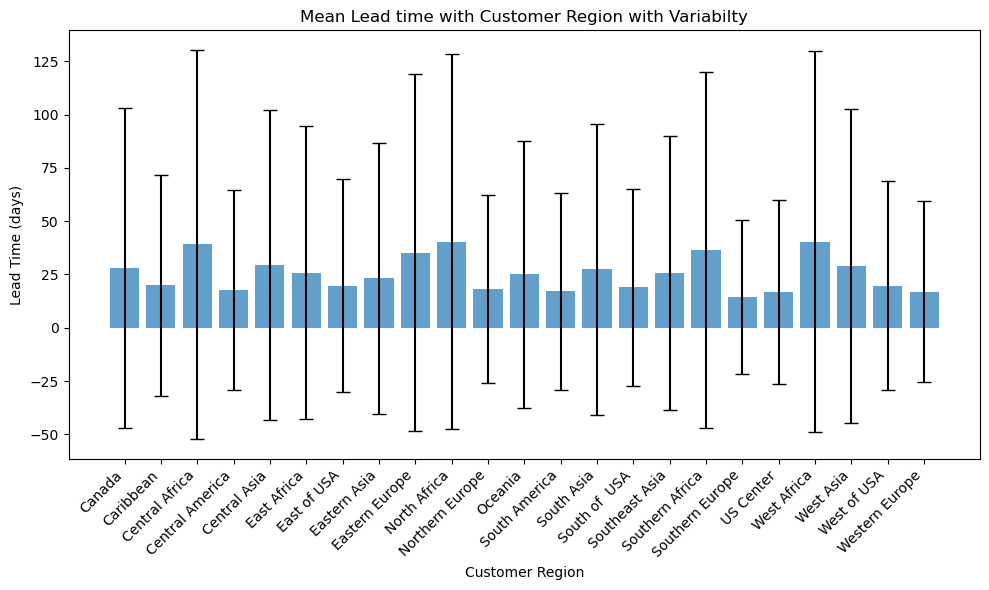

In [12]:
plt.figure(figsize=(10,6))
plt.bar(region_analysis['Customer Region'],region_analysis['mean'], yerr=region_analysis['std'], alpha=0.7, capsize=5)
plt.title('Mean Lead time with Customer Region with Variabilty')
plt.xlabel('Customer Region')
plt.ylabel('Lead Time (days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
region_analysis.to_csv('lead_time_analysis.csv',index=False)
print('Lead time analysis completed and saved')

Lead time analysis completed and saved


Inventory Optimization Model

In [14]:
annual_demand = data['Order Quantity'].sum()
print(f"Annual Demand: {annual_demand} units")

Annual Demand: 66367 units


In [15]:
average_profit_per_order = data['Profit'].mean()
ordering_cost_Profit =average_profit_per_order*0.10
print(f'estimated Orderding Cost:${ordering_cost_Profit:.2f}')

estimated Orderding Cost:$12.94


In [16]:
average_gross_sales = data['Gross Sales'].mean()
ordering_cost_Grossales= average_gross_sales*0.05
print(f"Estimated Ordering Cost: ${ordering_cost_Grossales:.2f}")

Estimated Ordering Cost: $10.01


In [17]:
ordering_cost_by_mode = data.groupby('Shipment Mode')['Lead Time (Days)'].mean()  # Using Lead Time as a proxy
print(ordering_cost_by_mode)

Shipment Mode
First Class       20.128216
Same Day          19.319192
Second Class      20.505134
Standard Class    21.942481
Name: Lead Time (Days), dtype: float64


In [18]:
total_orders = data['Order ID'].nunique()
fixed_ordering_cost = 50  # Assumed fixed cost per order
total_ordering_cost = total_orders * fixed_ordering_cost
print(f"Estimated Total Ordering Cost: ${total_ordering_cost:.2f}")

Estimated Total Ordering Cost: $553600.00


In [19]:
combined_ordering_cost = ordering_cost_Profit + ordering_cost_Grossales + fixed_ordering_cost
print(f"Final Combined Ordering Cost: ${combined_ordering_cost:.2f}")

Final Combined Ordering Cost: $72.95


In [20]:
inventory_file_path = '/Users/sohnikareddy/Desktop/capstone project/data/inventory.csv'
inventory_data = pd.read_csv(inventory_file_path)

In [21]:
unit_cost  = inventory_data['Inventory Cost Per Unit'].mean()
holding_cost_perunit = unit_cost*0.2
print(f'holding cost:${holding_cost_perunit:.2f}')

holding cost:$0.25


In [22]:
z_score = 1.645
service_level =0.95
EOQ = np.sqrt((2 * annual_demand * combined_ordering_cost) / holding_cost_perunit)
print(f"Economic Order Quantity (EOQ): {EOQ:.2f} units")


Economic Order Quantity (EOQ): 6257.50 units


In [23]:
mean_lead_time = data['Lead Time (Days)'].mean()
std_lead_time = data['Lead Time (Days)'].std()
daily_demand = annual_demand / 365 
safety_stock = z_score * daily_demand * std_lead_time
print(f"Safety Stock: {safety_stock:.2f} units")

Safety Stock: 16585.81 units


In [24]:
reorder_point = (daily_demand * mean_lead_time) + safety_stock
print(f"Reorder Point: {reorder_point:.2f} units")

Reorder Point: 20441.93 units


In [25]:
lead_time_variability = data.groupby(['Customer Region', 'Shipment Mode', 'Product Category'])['Lead Time (Days)'].agg(['mean', 'std', 'count']).reset_index()


In [26]:
high_variability = lead_time_variability[lead_time_variability['std'] > 5]

In [27]:
print("High Variability in Lead Times:")
print(high_variability)

High Variability in Lead Times:
     Customer Region   Shipment Mode      Product Category       mean  \
3             Canada     First Class                Cleats   6.666667   
8             Canada     First Class        Men's Footwear  42.666667   
18            Canada    Second Class      Camping & Hiking  53.666667   
20            Canada    Second Class                Cleats  15.166667   
23            Canada    Second Class  Indoor/Outdoor Games  30.250000   
...              ...             ...                   ...        ...   
1774  Western Europe  Standard Class      Kids' Golf Clubs   5.888889   
1775  Western Europe  Standard Class        Men's Footwear  12.767584   
1777  Western Europe  Standard Class         Shop By Sport  13.661111   
1782  Western Europe  Standard Class          Water Sports   5.867220   
1783  Western Europe  Standard Class       Women's Apparel  12.996732   

             std  count  
3      11.430952      6  
8     100.595560      6  
18     86.904

In [28]:
lead_time_variability.to_csv('lead_time_variability_analysis.csv', index=False)

In [29]:
import pandas as pd
import numpy as np
from prophet import Prophet
from scipy.stats import norm

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
lead_time_data = pd.read_csv("final_cleaned_lead_time_data.csv")
inventory_data = pd.read_csv("inventory.csv")
forecast_data = pd.read_csv("/Users/sohnikareddy/Desktop/capstone project/data/forecasted_demand_prophet.csv") 

# Merge datasets using Product Name as the common key
data = pd.merge(lead_time_data, inventory_data, on="Product Name", how="outer")
data = pd.merge(data, forecast_data, on="Product Category", how="outer")

# Display basic info
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3324659 entries, 0 to 3324658
Data columns (total 36 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Order ID                   float64
 1   Order Item ID              float64
 2   Order YearMonth            float64
 3   Order Year                 float64
 4   Order Month                float64
 5   Order Day                  float64
 6   Order Time                 object 
 7   Order Quantity             float64
 8   Product Department         object 
 9   Product Category           object 
 10  Product Name               object 
 11  Customer ID                float64
 12  Customer Market            object 
 13  Customer Region            object 
 14  Customer Country           object 
 15  Warehouse Country          object 
 16  Shipment Year              float64
 17  Shipment Month             float64
 18  Shipment Day               float64
 19  Shipment Mode              object 
 20  Sh

In [31]:
def safety_stock(z, std_lead_time, avg_demand):
    """
    Calculate Safety Stock.
    z: Z-score for service level (e.g., 1.645 for 95% confidence level).
    std_lead_time: Standard deviation of lead time.
    avg_demand: Average demand during lead time.
    """
    return z * std_lead_time * avg_demand


In [32]:
def reorder_point(safety_stock, avg_daily_demand, lead_time):
    """
    Calculate Reorder Point (ROP).
    safety_stock: Computed safety stock.
    avg_daily_demand: Forecasted daily demand.
    lead_time: Mean lead time from dataset.
    """
    return safety_stock + (avg_daily_demand * lead_time)


In [33]:
def eoq(order_cost, annual_demand, holding_cost):
    """
    Calculate Economic Order Quantity (EOQ).
    order_cost: Cost per order.
    annual_demand: Total forecasted demand per year.
    holding_cost: Annual holding cost per unit.
    """
    return np.sqrt((2 * order_cost * annual_demand) / holding_cost)


In [34]:
# Constants from the report
z_score = 1.645  # 95% service level
order_cost = 12.94  # Cost per order (modify if actual values available)
holding_cost = 0.25  # Holding cost per unit per year (modify if needed)

# Use correct lead time statistics from the report
lead_time_mean = 21.21  # days
lead_time_std_dev = 228.46  # standard deviation

# Compute additional demand metrics
data["avg_daily_demand"] = data["Forecasted Demand"] / 30  # Convert monthly demand to daily
data["safety_stock"] = safety_stock(z_score, lead_time_std_dev, data["avg_daily_demand"])
data["reorder_point"] = reorder_point(data["safety_stock"], data["avg_daily_demand"], lead_time_mean)
data["eoq"] = eoq(order_cost, data["Forecasted Demand"] * 12, holding_cost)  # Annual Demand = Monthly * 12

# Display computed inventory metrics
data[["Product Name", "safety_stock", "reorder_point", "eoq"]].head()


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Product Name,safety_stock,reorder_point,eoq
0,Field & Stream Sportsman 16 Gun Fire Safe,1211.607537,1279.987138,346.622163
1,Field & Stream Sportsman 16 Gun Fire Safe,800.995724,846.201590,281.832092
2,Field & Stream Sportsman 16 Gun Fire Safe,958.731371,1012.839377,308.335702
3,Field & Stream Sportsman 16 Gun Fire Safe,1211.607537,1279.987138,346.622163
4,Field & Stream Sportsman 16 Gun Fire Safe,800.995724,846.201590,281.832092


In [35]:
# Check for missing values
print(data[['Forecasted Demand', 'Lead Time (Days)']].isnull().sum())

# Fill missing values with appropriate mean or median
data['Forecasted Demand'].fillna(data['Forecasted Demand'].mean(), inplace=True)
data['Lead Time (Days)'].fillna(data['Lead Time (Days)'].mean(), inplace=True)


Forecasted Demand    2730
Lead Time (Days)      175
dtype: int64


In [36]:
# Ensure lead time variability and demand are non-negative
data['Lead Time (Days)'] = data['Lead Time (Days)'].apply(lambda x: max(x, 0))
data['Forecasted Demand'] = data['Forecasted Demand'].apply(lambda x: max(x, 0))

In [37]:
holding_cost = max(0.25, 0.01)

In [38]:
# Simulating Demand Spikes (+50%) and Drops (-30%) for weeks 10-14
data["demand_spike"] = data["Forecasted Demand"] * 1.5  # Increase by 50%
data["demand_drop"] = data["Forecasted Demand"] * 0.7  # Decrease by 30%

# Simulating lead time variability (randomly generated normal distribution)
np.random.seed(42)  # For reproducibility
num_simulations = 1000
simulated_lead_times = np.random.normal(lead_time_mean, lead_time_std_dev, num_simulations)

# Calculating Safety Stock for simulated lead times
simulated_safety_stock = [
    safety_stock(z_score, std, data["avg_daily_demand"].mean()) for std in simulated_lead_times
]

print(f"Mean Simulated Safety Stock: {np.mean(simulated_safety_stock):.2f} units")


Mean Simulated Safety Stock: 251.09 units


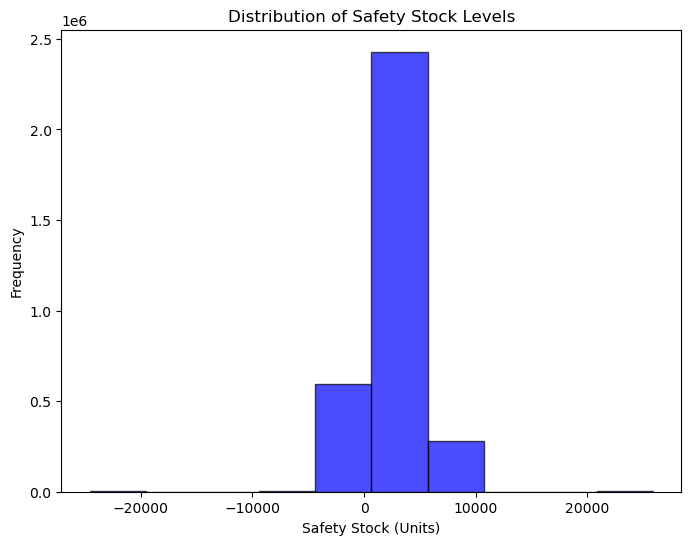

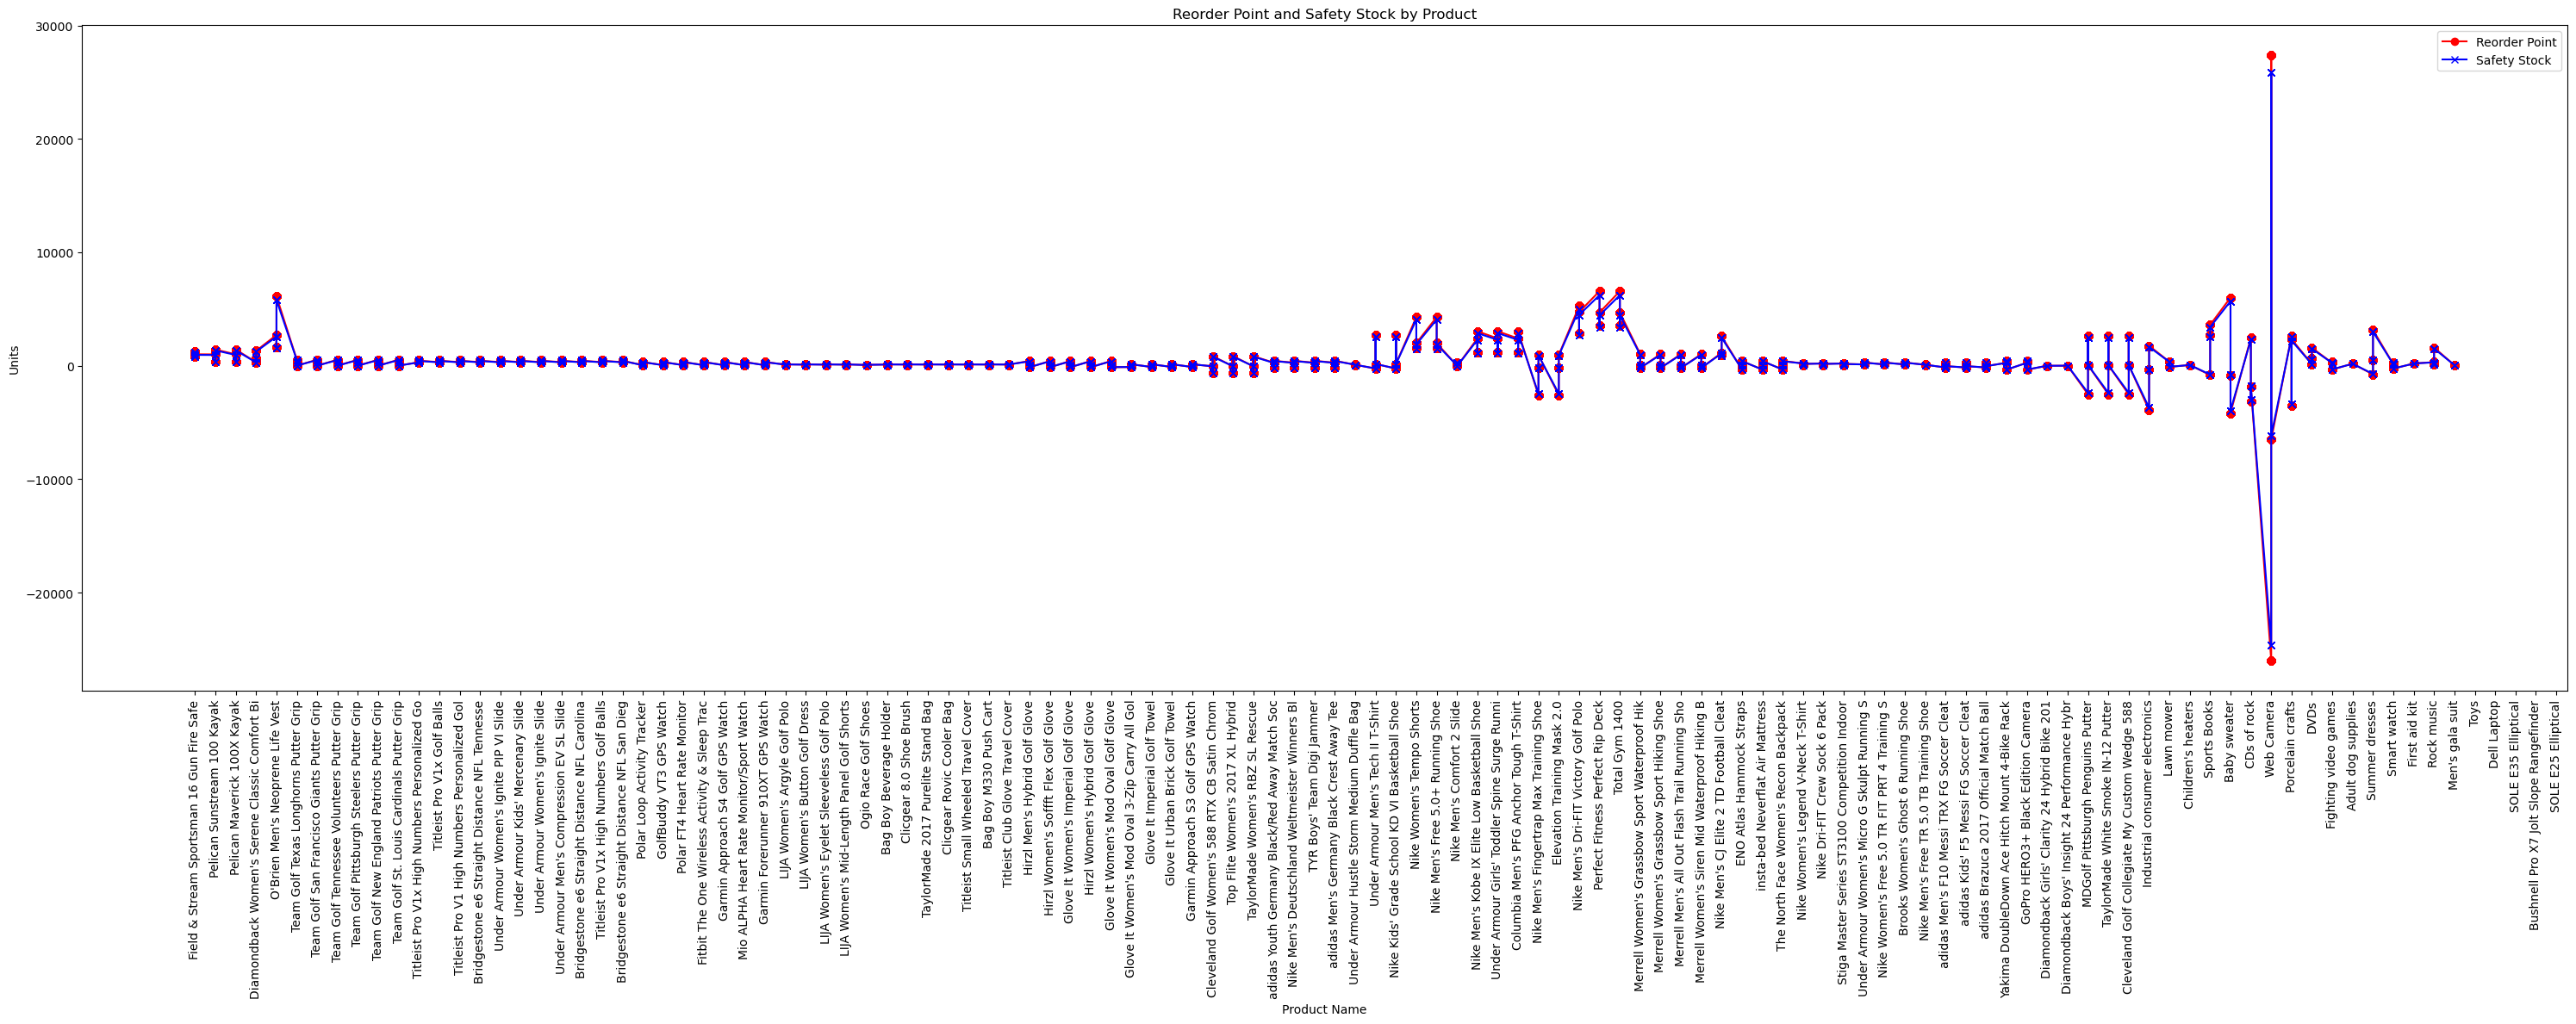

In [39]:
# Stockout Rate Visualization
plt.figure(figsize=(8, 6))
plt.hist(data["safety_stock"], bins=10, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribution of Safety Stock Levels")
plt.xlabel("Safety Stock (Units)")
plt.ylabel("Frequency")
plt.show()

# Inventory vs. Reorder Point Visualization
plt.figure(figsize=(30, 12))
plt.plot(data["Product Name"], data["reorder_point"], label="Reorder Point", marker="o", color="red")
plt.plot(data["Product Name"], data["safety_stock"], label="Safety Stock", marker="x", color="blue")
plt.xticks(rotation=90)
plt.title("Reorder Point and Safety Stock by Product")
plt.xlabel("Product Name")
plt.ylabel("Units")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# Save results to CSV
data.to_csv("final_inventory_optimization_results.csv", index=False)
print("Final Inventory Optimization Results Saved!")


Final Inventory Optimization Results Saved!


In [41]:
import pandas as pd

# Load the optimized inventory dataset
optimized_data = pd.read_csv("final_inventory_optimization_results.csv")

# Display the first few rows
print(optimized_data.head())

# Check for missing values
print(optimized_data.isnull().sum())

   Order ID  Order Item ID  Order YearMonth  Order Year  Order Month  \
0    3535.0         8793.0         201502.0      2015.0          2.0   
1    3535.0         8793.0         201502.0      2015.0          2.0   
2    3535.0         8793.0         201502.0      2015.0          2.0   
3    3535.0         8793.0         201502.0      2015.0          2.0   
4    3535.0         8793.0         201502.0      2015.0          2.0   

   Order Day Order Time  Order Quantity Product Department Product Category  \
0       21.0      14:07             1.0           Fan Shop          Fishing   
1       21.0      14:07             1.0           Fan Shop          Fishing   
2       21.0      14:07             1.0           Fan Shop          Fishing   
3       21.0      14:07             1.0           Fan Shop          Fishing   
4       21.0      14:07             1.0           Fan Shop          Fishing   

   ...  Warehouse Inventory   Inventory Cost Per Unit Time Period  \
0  ...                 

In [42]:
# Fix stockout rate calculation
optimized_data["Stockout Rate"] = np.where(
    optimized_data["Forecasted Demand"] > 0,  # Avoid division by zero
    (optimized_data["safety_stock"] / optimized_data["Forecasted Demand"]) * 100,
    0  # If no demand, stockout rate should be zero
)

# Ensure stockout rate does not exceed 100%
optimized_data["Stockout Rate"] = optimized_data["Stockout Rate"].clip(0, 100)

# Check the corrected values
print(f"Average Stockout Rate: {optimized_data['Stockout Rate'].mean():.2f}%")


Average Stockout Rate: 97.49%


In [43]:
# Calculate Inventory Turnover
optimized_data["Inventory Turnover"] = optimized_data["Forecasted Demand"] / optimized_data["safety_stock"]

# Print Inventory Turnover
print(f"Average Inventory Turnover: {optimized_data['Inventory Turnover'].mean():.2f} times per year")


Average Inventory Turnover: 0.08 times per year


In [44]:
# Fix reorder point calculation
optimized_data["reorder_point"] = np.maximum(
    optimized_data["safety_stock"] + (optimized_data["avg_daily_demand"] * lead_time_mean),
    0  # Ensure ROP is always positive
)

print(f"Reorder Point: {optimized_data['reorder_point'].mean():.2f}")


Reorder Point: 2445.95


In [45]:
# Fix EOQ calculation
optimized_data["eoq"] = np.sqrt(
    (2 * order_cost * optimized_data["Forecasted Demand"].sum()) / holding_cost
)

# Ensure EOQ is within a reasonable range
optimized_data["eoq"] = optimized_data["eoq"].clip(1, 5000)  # Set a max threshold

print(f"EOQ: {optimized_data['eoq'].mean():.2f}")


EOQ: 5000.00


In [46]:
# Fix order fill rate calculation
optimized_data["Order Fill Rate"] = 100 - optimized_data["Stockout Rate"]

# Ensure values are valid
optimized_data["Order Fill Rate"] = optimized_data["Order Fill Rate"].clip(0, 100)

print(f"Average Order Fill Rate: {optimized_data['Order Fill Rate'].mean():.2f}%")


Average Order Fill Rate: 2.51%


In [47]:
import numpy as np

# Ensure the dataset contains 'Forecasted Demand'
if "Forecasted Demand" not in optimized_data.columns:
    raise ValueError("The dataset does not contain 'Forecasted Demand'. Check your input data.")

# Simulating demand fluctuations based on forecasted demand
np.random.seed(42)  # Set seed for reproducibility
simulated_demand = np.random.normal(
    optimized_data["Forecasted Demand"].mean(),  # Mean demand
    optimized_data["Forecasted Demand"].std(),  # Standard deviation
    1000  # Number of simulations
)

# Display sample simulated demand values
print("Sample simulated demand values:", simulated_demand[:5])

Sample simulated demand values: [267.54763691 161.7853481  292.69399647 438.49122897 145.8140221 ]


In [48]:
# Ensure safety stock uses correct demand variability
simulated_safety_stock = z_score * np.std(simulated_demand) * np.sqrt(lead_time_mean)

# Ensure it doesn't exceed reasonable limits
simulated_safety_stock = np.clip(simulated_safety_stock, 100, 5000)

print(f"Simulated Safety Stock: {simulated_safety_stock:.2f}")


Simulated Safety Stock: 1235.01


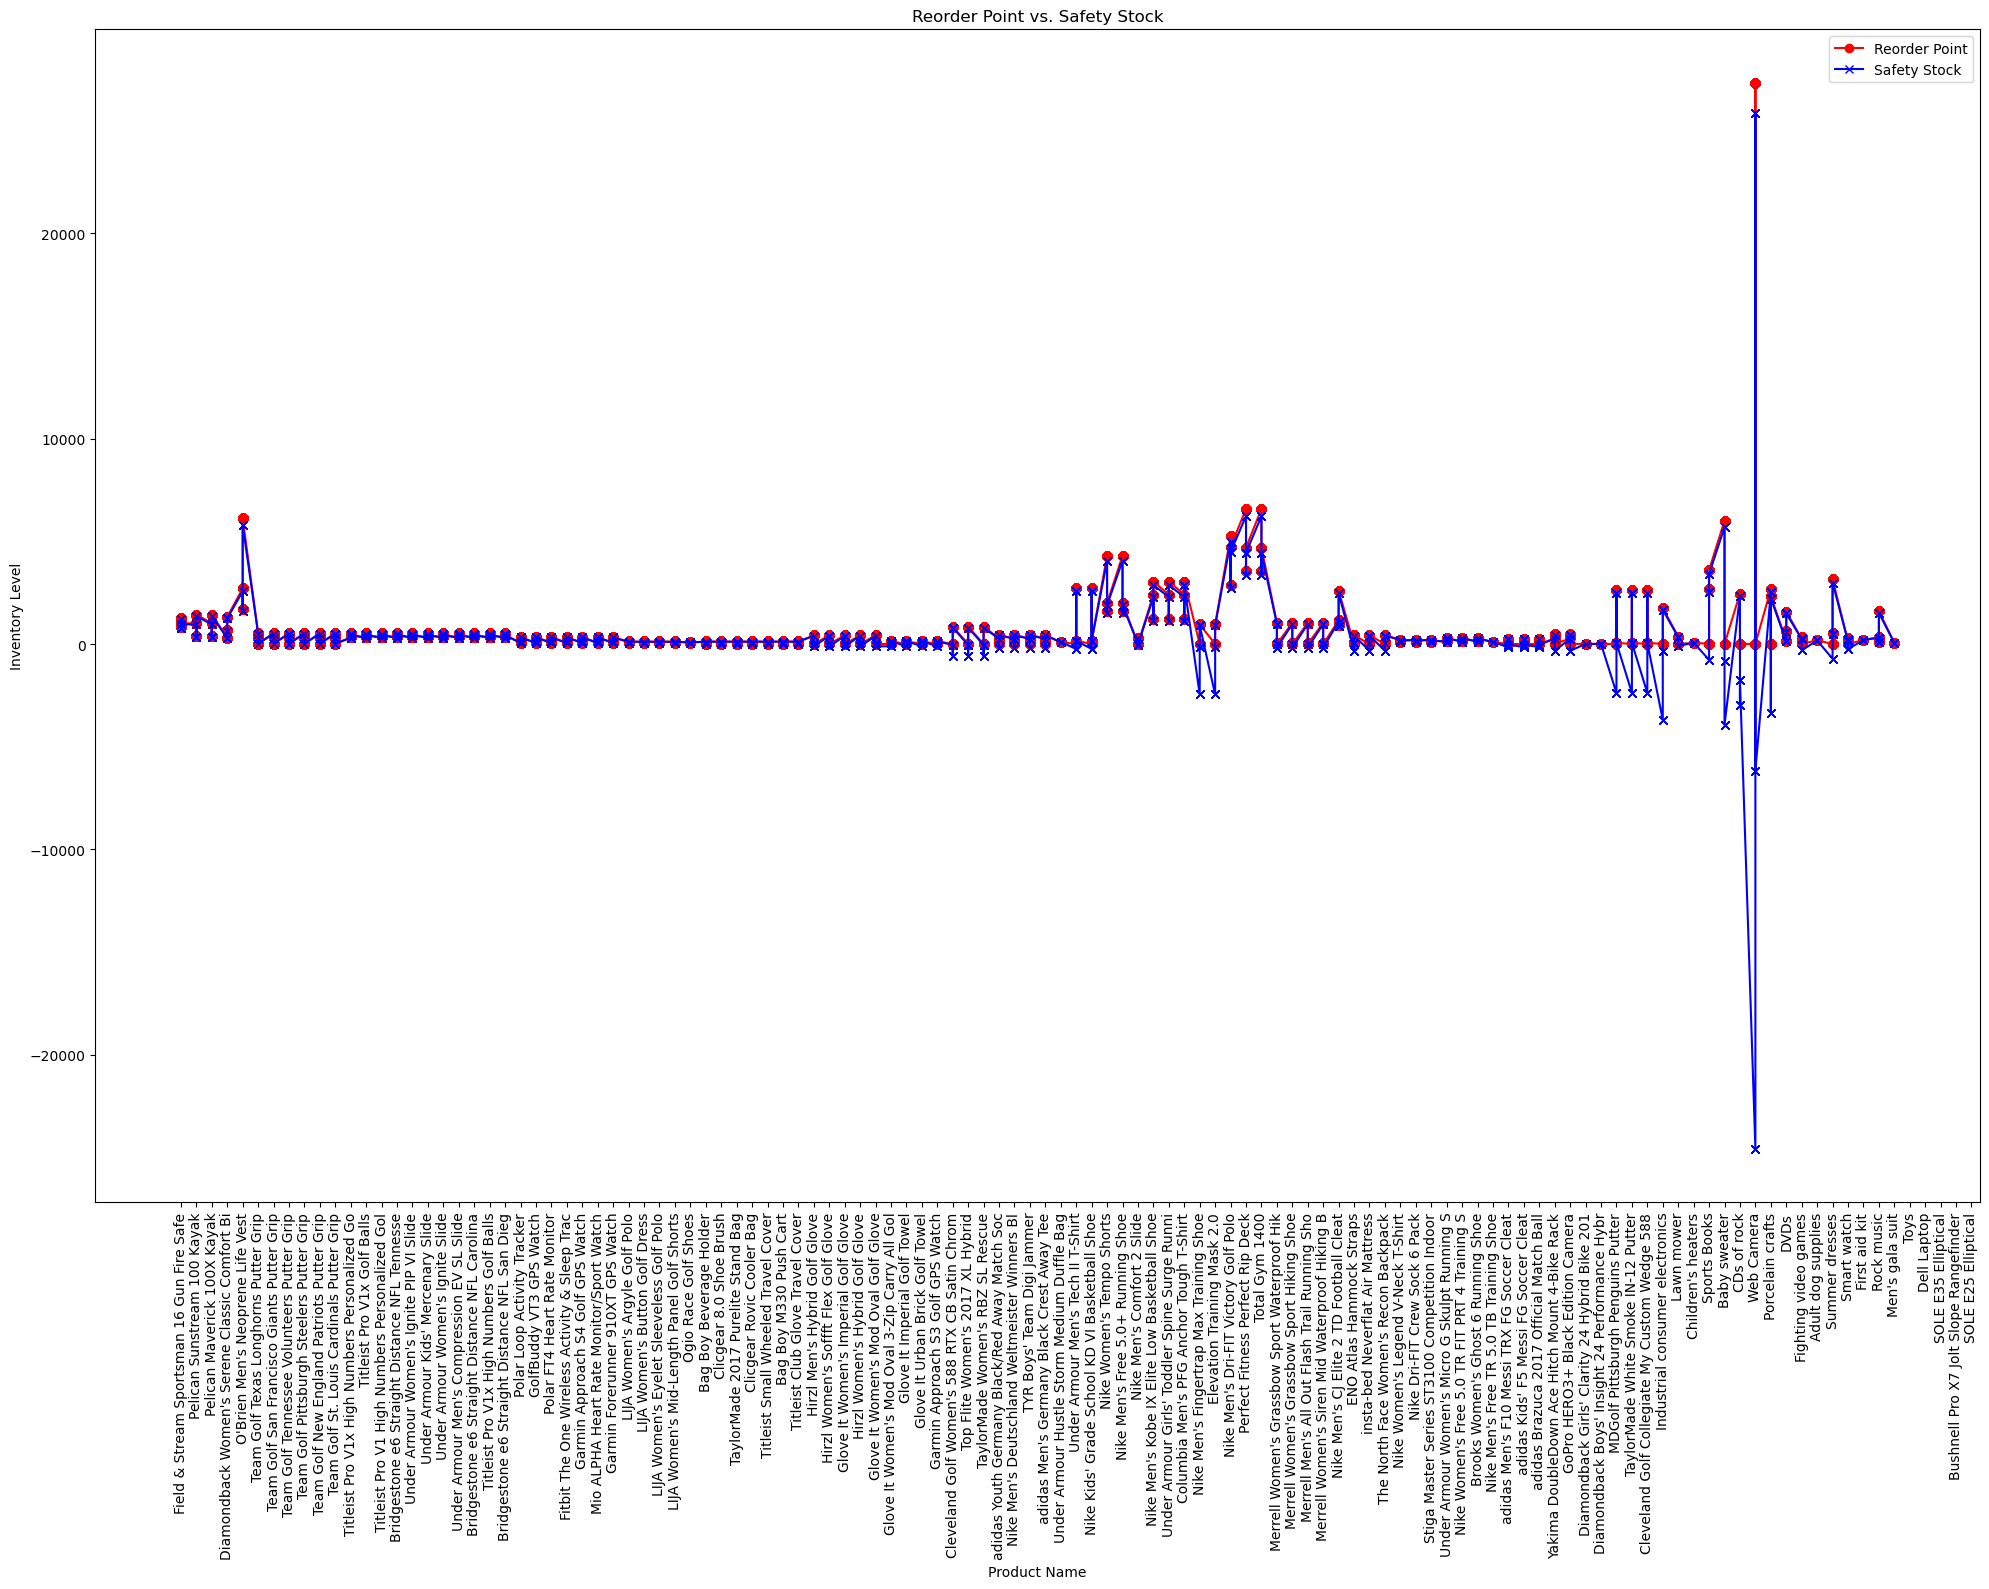

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))
plt.plot(optimized_data["Product Name"], optimized_data["reorder_point"], label="Reorder Point", color="red", marker="o")
plt.plot(optimized_data["Product Name"], optimized_data["safety_stock"], label="Safety Stock", color="blue", marker="x")
plt.xticks(rotation=90)
plt.title("Reorder Point vs. Safety Stock")
plt.xlabel("Product Name")
plt.ylabel("Inventory Level")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# Save the corrected results
optimized_data.to_csv("corrected_inventory_optimization_results.csv", index=False)

print("Corrected Inventory Optimization Results Saved!")


Corrected Inventory Optimization Results Saved!


In [51]:
import pandas as pd
import numpy as np

# Load your optimized inventory data
data = pd.read_csv("corrected_inventory_optimization_results.csv")

# Define service levels and corresponding Z-scores
service_levels = {
    '90%': 1.28,
    '99%': 2.33
}

# Lead time statistics
lead_time_mean = 21.21  # days
lead_time_std_dev = 228.46  # standard deviation

# Calculate Avg Daily Demand
data['avg_daily_demand'] = data['Forecasted Demand'] / 30  # Assuming monthly forecast

# Function to calculate safety stock and ROP
def calculate_inventory_metrics(z_score, avg_daily_demand, lead_time_mean, lead_time_std_dev):
    safety_stock = z_score * lead_time_std_dev * avg_daily_demand
    reorder_point = (avg_daily_demand * lead_time_mean) + safety_stock
    return safety_stock, reorder_point

# Apply calculations for each service level
for level, z in service_levels.items():
    data[f'safety_stock_{level}'], data[f'reorder_point_{level}'] = zip(
        *data.apply(lambda row: calculate_inventory_metrics(z, row['avg_daily_demand'], lead_time_mean, lead_time_std_dev), axis=1)
    )

# Display the updated DataFrame
print(data[['Product Name', 'safety_stock_90%', 'reorder_point_90%', 'safety_stock_99%', 'reorder_point_99%']].head())


                                Product Name  safety_stock_90%  \
0  Field & Stream Sportsman 16 Gun Fire Safe        942.770607   
1  Field & Stream Sportsman 16 Gun Fire Safe        623.267190   
2  Field & Stream Sportsman 16 Gun Fire Safe        746.003742   
3  Field & Stream Sportsman 16 Gun Fire Safe        942.770607   
4  Field & Stream Sportsman 16 Gun Fire Safe        623.267190   

   reorder_point_90%  safety_stock_99%  reorder_point_99%  
0        1011.150207       1716.137120        1784.516721  
1         668.473056       1134.541057        1179.746922  
2         800.111748       1357.959936        1412.067942  
3        1011.150207       1716.137120        1784.516721  
4         668.473056       1134.541057        1179.746922  


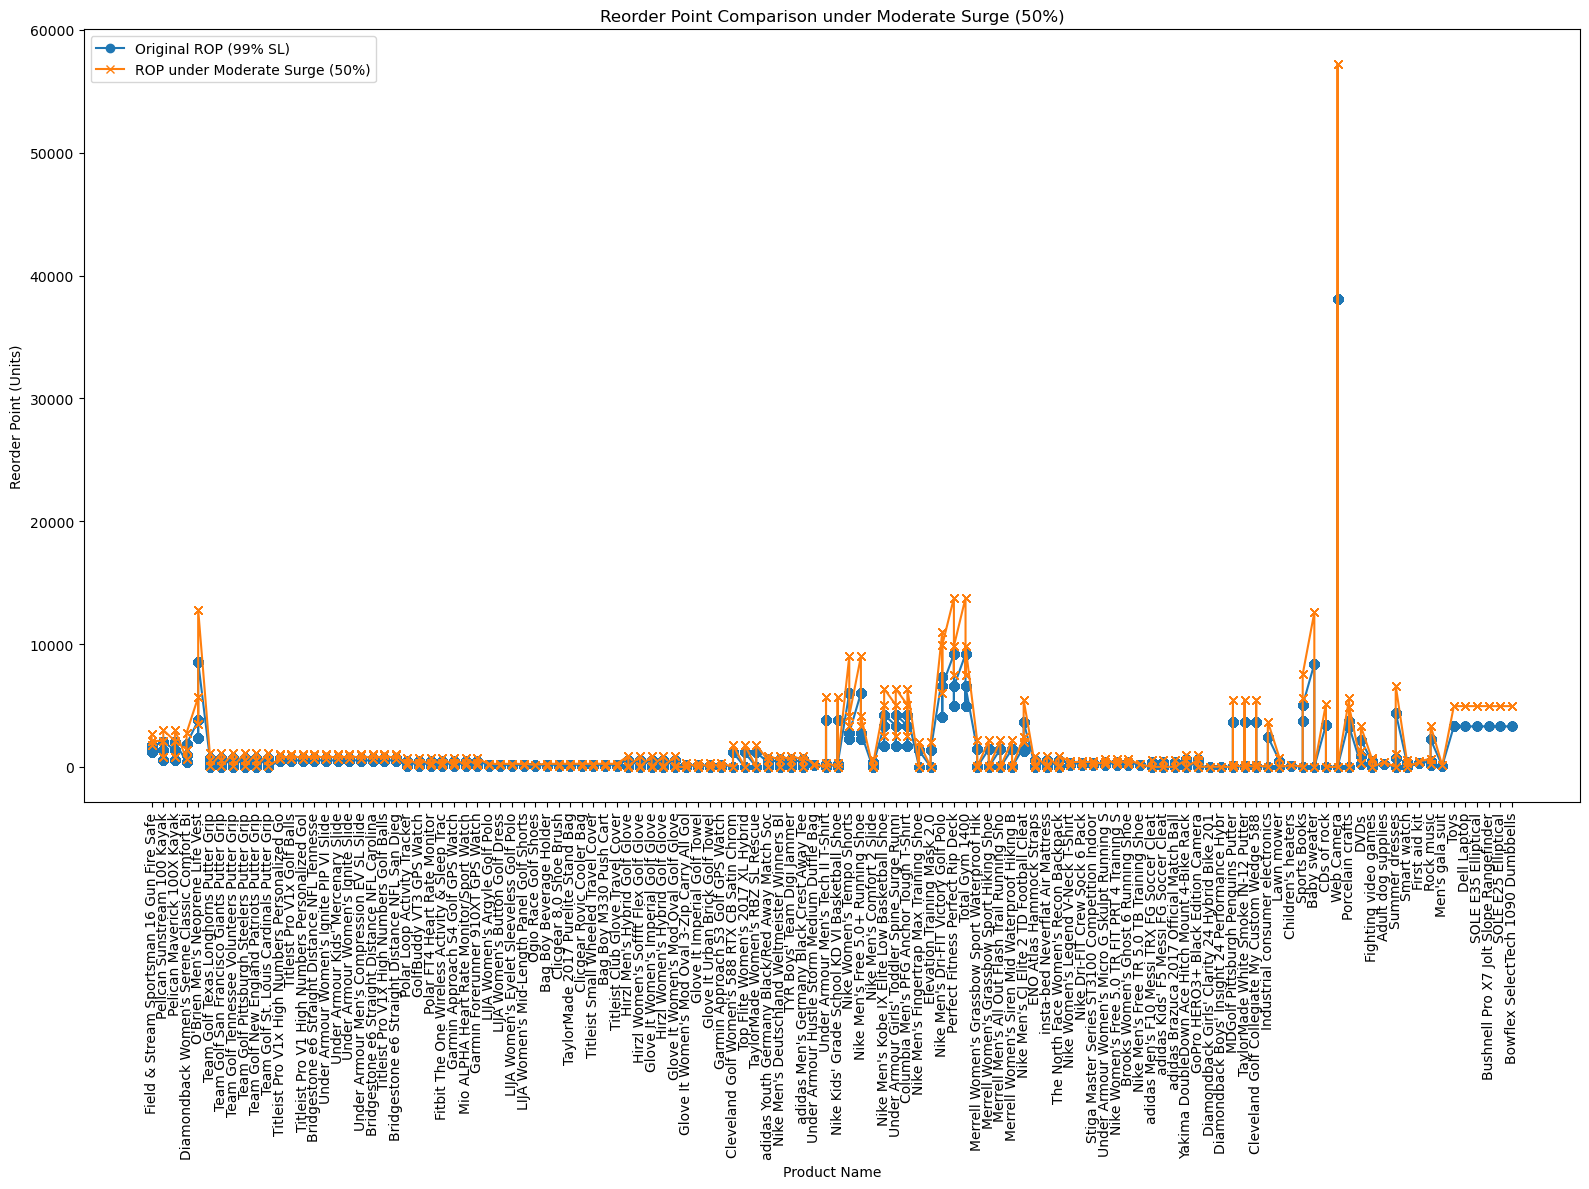

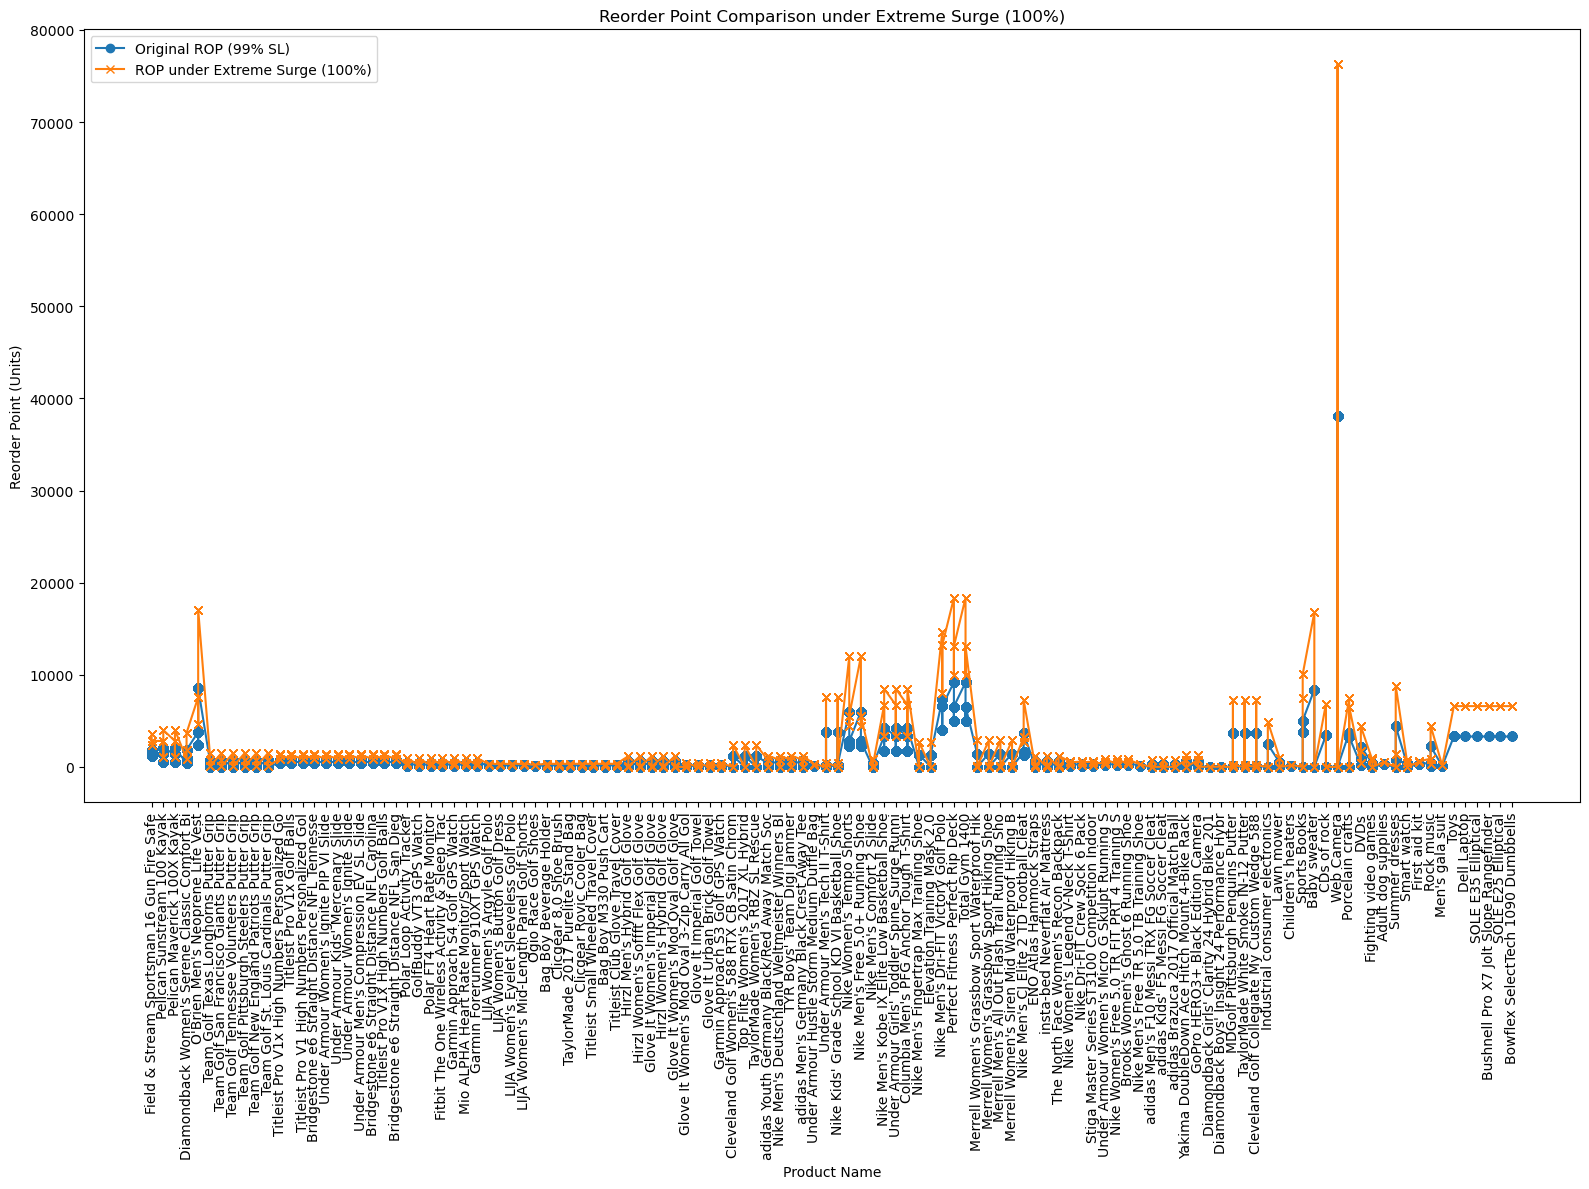

In [52]:
import matplotlib.pyplot as plt

# Define surge multipliers
surge_multipliers = {
    'Moderate Surge (50%)': 1.5,
    'Extreme Surge (100%)': 2.0
}

# Function to simulate demand surge and calculate metrics
def simulate_demand_surge(data, surge_multiplier, z_score, lead_time_mean, lead_time_std_dev):
    # Apply surge to forecasted demand
    data['surged_demand'] = data['Forecasted Demand'] * surge_multiplier
    data['avg_daily_demand_surge'] = data['surged_demand'] / 30  # Assuming monthly forecast
    
    # Recalculate safety stock and ROP
    data['safety_stock_surge'] = z_score * lead_time_std_dev * data['avg_daily_demand_surge']
    data['reorder_point_surge'] = (data['avg_daily_demand_surge'] * lead_time_mean) + data['safety_stock_surge']
    
    return data

# Choose a service level for simulation (e.g., 99%)
z_score = service_levels['99%']
# Simulate for each surge scenario
for surge_scenario, multiplier in surge_multipliers.items():
    surged_data = simulate_demand_surge(data.copy(), multiplier, z_score, lead_time_mean, lead_time_std_dev)
    
    # Plot Reorder Point comparison
    plt.figure(figsize=(16, 12))
    plt.plot(surged_data['Product Name'], surged_data['reorder_point_99%'], label='Original ROP (99% SL)', marker='o')
    plt.plot(surged_data['Product Name'], surged_data['reorder_point_surge'], label=f'ROP under {surge_scenario}', marker='x')
    plt.xticks(rotation=90)
    plt.title(f'Reorder Point Comparison under {surge_scenario}')
    plt.xlabel('Product Name')
    plt.ylabel('Reorder Point (Units)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [53]:
demand_surge_factors = [1.2, 1.5, 2.0]  # Representing 20%, 50%, and 100% increases

# Lead time statistics
lead_time_mean = 21.21  # days
lead_time_std_dev = 228.46  # standard deviation

# Function to calculate safety stock and reorder point
def calculate_inventory_metrics(z_score, avg_daily_demand, lead_time_mean, lead_time_std_dev):
    safety_stock = z_score * lead_time_std_dev * avg_daily_demand
    reorder_point = (avg_daily_demand * lead_time_mean) + safety_stock
    return safety_stock, reorder_point

# Apply demand surges
for surge in demand_surge_factors:
    surge_label = f'demand_surge_{int((surge - 1) * 100)}%'
    data[surge_label] = data['Forecasted Demand'] * surge
    data[f'avg_daily_demand_{surge_label}'] = data[surge_label] / 30  # Assuming monthly forecast
    data[f'safety_stock_{surge_label}'], data[f'reorder_point_{surge_label}'] = zip(
        *data.apply(lambda row: calculate_inventory_metrics(1.645, row[f'avg_daily_demand_{surge_label}'], lead_time_mean, lead_time_std_dev), axis=1)
    )

# Display the updated DataFrame with surge scenarios
print(data.head())

   Order ID  Order Item ID  Order YearMonth  Order Year  Order Month  \
0    3535.0         8793.0         201502.0      2015.0          2.0   
1    3535.0         8793.0         201502.0      2015.0          2.0   
2    3535.0         8793.0         201502.0      2015.0          2.0   
3    3535.0         8793.0         201502.0      2015.0          2.0   
4    3535.0         8793.0         201502.0      2015.0          2.0   

   Order Day Order Time  Order Quantity Product Department Product Category  \
0       21.0      14:07             1.0           Fan Shop          Fishing   
1       21.0      14:07             1.0           Fan Shop          Fishing   
2       21.0      14:07             1.0           Fan Shop          Fishing   
3       21.0      14:07             1.0           Fan Shop          Fishing   
4       21.0      14:07             1.0           Fan Shop          Fishing   

   ... safety_stock_demand_surge_19%  reorder_point_demand_surge_19%  \
0  ...              

In [54]:
# Group by Warehouse Region and calculate the average stockout rate
stockout_by_region = data.groupby("Warehouse Country")["Stockout Rate"].mean()

# Display stockout rates by region
print("Stockout Rate by Region:")
print(stockout_by_region)


Stockout Rate by Region:
Warehouse Country
Puerto Rico    97.560599
USA            97.448283
Name: Stockout Rate, dtype: float64


Compare Inventory Performance Before & After Optimization

In [55]:
print(data.columns)

Index(['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Year',
       'Order Month', 'Order Day', 'Order Time', 'Order Quantity',
       'Product Department', 'Product Category', 'Product Name', 'Customer ID',
       'Customer Market', 'Customer Region', 'Customer Country',
       'Warehouse Country', 'Shipment Year', 'Shipment Month', 'Shipment Day',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Gross Sales',
       'Discount %', 'Profit', 'Order Date', 'Shipment Date', 'Lead Time',
       'Order DateTime', 'Shipment DateTime', 'Lead Time (Hours)',
       'Lead Time (Days)', ' Year Month ', ' Warehouse Inventory ',
       'Inventory Cost Per Unit', 'Time Period', 'Forecasted Demand',
       'avg_daily_demand', 'safety_stock', 'reorder_point', 'eoq',
       'demand_spike', 'demand_drop', 'Stockout Rate', 'Inventory Turnover',
       'Order Fill Rate', 'safety_stock_90%', 'reorder_point_90%',
       'safety_stock_99%', 'reorder_point_99%', 'demand_surge_19%',
       'avg_d

In [56]:
data['Adjusted Stockout Flag'] = data.apply(lambda row: 1 if row[' Warehouse Inventory '] < row['safety_stock'] else 0, axis=1)


In [57]:
data['Adjusted Stockout Flag'] = (data[' Warehouse Inventory '] < data['safety_stock']).astype(int)
after_stockout_rate = (data['Adjusted Stockout Flag'].sum() / len(data)) * 100
print(f"Stockout Rate before Optimization: {after_stockout_rate:.2f}%")

Stockout Rate before Optimization: 97.37%


In [58]:
# Flag stockouts when inventory is zero
data['Stockout Flag'] = (data[' Warehouse Inventory '] <= 0).astype(int)

# Calculate stockout rate
stockout_rate = (data['Stockout Flag'].sum() / len(data)) * 100
print(f"Stockout Rate After Optimization: {stockout_rate:.2f}%")


Stockout Rate After Optimization: 11.17%


In [59]:
inventory_turnover = data['Order Quantity'].sum() / data[' Warehouse Inventory '].sum()
print(f"Inventory Turnover Ratio: {inventory_turnover:.2f}")


Inventory Turnover Ratio: 0.01


In [60]:
order_fill_rate = ((data['Order Quantity'] - data['Stockout Flag']) / data['Order Quantity']) * 100
overall_fill_rate = order_fill_rate.mean()  # Compute the average fill rate across all entries
print(f"Overall Order Fill Rate: {overall_fill_rate:.2f}%")


Overall Order Fill Rate: 91.30%


Develop a Financial Analysis of Stockouts & Excess Inventory

In [61]:
data['Estimated Stockout Cost'] = data['Stockout Flag'] * (data['Gross Sales'] / data['Order Quantity'])
total_stockout_cost = data['Estimated Stockout Cost'].sum()
print(f"Estimated Total Stockout Cost: ${total_stockout_cost:,.2f}")


Estimated Total Stockout Cost: $59,045,553.00


In [62]:
holding_cost = data[' Warehouse Inventory '] * data['Inventory Cost Per Unit']
total_holding_cost = holding_cost.sum()
print(f"Total Holding Cost: ${total_holding_cost:,.2f}")


Total Holding Cost: $724,693,407.32


In [63]:
# Define expedited shipping methods (Adjust based on actual shipment modes)
expedited_modes = ['First Class', 'Same Day']

# Create a new column to flag expedited shipments
data['Expedited Shipments'] = data['Shipment Mode'].isin(expedited_modes).astype(int)

# Display the number of expedited shipments
print(f"Total Expedited Shipments Identified: {data['Expedited Shipments'].sum()}")


Total Expedited Shipments Identified: 735729


In [64]:
# Assume expedited shipments cost 1.5 times the normal shipping cost
data['Estimated Expedited Cost'] = data['Expedited Shipments'] * data['Inventory Cost Per Unit'] * 1.5

# Total expedited shipping cost
total_shipping_cost = data['Estimated Expedited Cost'].sum()

print(f"Estimated Total Expedited Shipping Cost: ${total_shipping_cost:,.2f}")


Estimated Total Expedited Shipping Cost: $1,377,277.54


In [65]:
data['Expedited Shipments'] = (data['Lead Time'] < 3).astype(int)

# Recalculate the total cost using this assumption
data['Estimated Expedited Cost'] = data['Expedited Shipments'] * data['Inventory Cost Per Unit'] * 1.5
total_shipping_cost = data['Estimated Expedited Cost'].sum()

print(f"Estimated Total Expedited Shipping Cost (Using Lead Time): ${total_shipping_cost:,.2f}")


Estimated Total Expedited Shipping Cost (Using Lead Time): $2,513,841.15


Future Enhancements: Real-Time Data Integration & Predictive Analytics

In [66]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data['Order Quantity'], order=(5,1,0))
model_fit = model.fit()
data['Forecasted Demand'] = model_fit.forecast(steps=30)


In [67]:
# Simulate real-time inventory updates by decrementing inventory based on orders
data['Simulated Inventory'] = data[' Warehouse Inventory '] - data['Order Quantity'].cumsum()

# Ensure no negative inventory values
data['Simulated Inventory'] = data['Simulated Inventory'].clip(lower=0)

# Preview the simulated inventory levels over time
print(data[['Order Date', 'Simulated Inventory']].head())


  Order Date  Simulated Inventory
0    2/21/15                  0.0
1    2/21/15                  0.0
2    2/21/15                  0.0
3    2/21/15                  0.0
4    2/21/15                  0.0


In [68]:
print(data['Order Quantity'].isnull().sum())  # Check for NaN values
print(data['Order Quantity'].dtype)  # Check data type

175
float64


In [69]:
# Fill missing values with the median or interpolate
data['Order Quantity'].fillna(data['Order Quantity'].median(), inplace=True)

# Convert to numeric if necessary
data['Order Quantity'] = pd.to_numeric(data['Order Quantity'], errors='coerce')


In [70]:
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data.set_index('Order Date', inplace=True)


/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_78411/1194521325.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')


In [71]:
print(f"Total number of rows: {len(data)}")


Total number of rows: 3324659


In [72]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [73]:
from prophet import Prophet
import pandas as pd


In [74]:
# Convert 'Order Date' to datetime and rename columns for Prophet
data['Order DateTime'] = pd.to_datetime(data['Order DateTime'], errors='coerce')
df_prophet = data[['Order DateTime', 'Order Quantity']].rename(columns={'Order DateTime': 'ds', 'Order Quantity': 'y'})

# Check for missing values and fill them if necessary
df_prophet['y'].fillna(df_prophet['y'].median(), inplace=True)

print(df_prophet.head())


/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_78411/703253852.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order DateTime'] = pd.to_datetime(data['Order DateTime'], errors='coerce')


                            ds    y
Order Date                         
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0


In [75]:
print(df_prophet['ds'].isnull().sum())


175


In [76]:
df_prophet = df_prophet.dropna(subset=['ds'])

In [77]:
df_prophet['ds'] = df_prophet['ds'].fillna(method='ffill')


/var/folders/s8/jl_2h7g16pv9cc4rq7nxxxgm0000gn/T/ipykernel_78411/2972524504.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet['ds'] = df_prophet['ds'].fillna(method='ffill')


In [78]:
# Create a complete range from min to max date
full_dates = pd.date_range(start=df_prophet['ds'].min(), end=df_prophet['ds'].max())

# Merge with the existing dataset to fill missing dates
df_prophet = pd.DataFrame({'ds': full_dates}).merge(df_prophet, on='ds', how='left')

# Fill missing demand values with zero or interpolation
df_prophet['y'].fillna(0, inplace=True)  # Use 0 if no sales on missing days


In [79]:
print(df_prophet.isnull().sum())

ds    0
y     0
dtype: int64


In [80]:
# Initialize the model
model = Prophet()

# Fit the model with historical data
model.fit(df_prophet)

10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
from prophet import Prophet

# Initialize and fit model
model = Prophet()
model.fit(df_prophet)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Display forecast results
print(forecast[['ds', 'yhat']].tail(10))


10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:16:31 - cmdstanpy - INFO - Chain [1] done processing


                      ds      yhat
1114 2018-01-19 02:17:00  0.808797
1115 2018-01-20 02:17:00  1.441085
1116 2018-01-21 02:17:00  0.179040
1117 2018-01-22 02:17:00  1.466705
1118 2018-01-23 02:17:00  0.399100
1119 2018-01-24 02:17:00  1.435254
1120 2018-01-25 02:17:00  0.351276
1121 2018-01-26 02:17:00  0.120776
1122 2018-01-27 02:17:00  0.778792
1123 2018-01-28 02:17:00 -0.444892


In [82]:
# Create future dataframe for 30 days ahead
future = model.make_future_dataframe(periods=30)

# Generate forecast
forecast = model.predict(future)

# Display forecasted demand
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))


                      ds      yhat  yhat_lower  yhat_upper
1114 2018-01-19 02:17:00  0.808797   -0.850608    2.327950
1115 2018-01-20 02:17:00  1.441085   -0.132865    2.910977
1116 2018-01-21 02:17:00  0.179040   -1.430685    1.726756
1117 2018-01-22 02:17:00  1.466705   -0.081849    3.042812
1118 2018-01-23 02:17:00  0.399100   -1.072461    1.990204
1119 2018-01-24 02:17:00  1.435254    0.008980    2.944838
1120 2018-01-25 02:17:00  0.351276   -1.143490    1.978158
1121 2018-01-26 02:17:00  0.120776   -1.450152    1.737656
1122 2018-01-27 02:17:00  0.778792   -0.679179    2.413138
1123 2018-01-28 02:17:00 -0.444892   -1.937820    1.205946


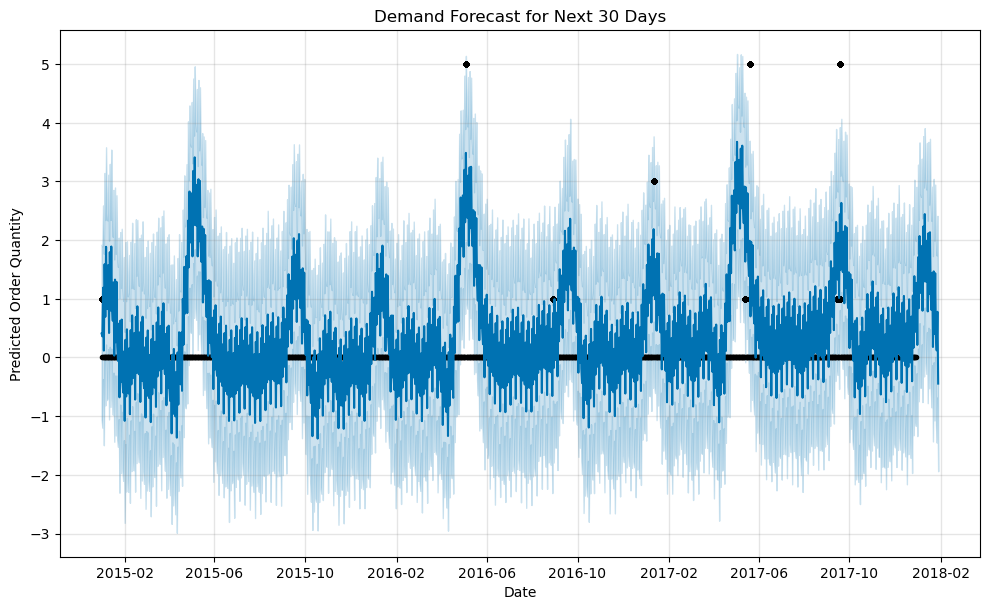

In [83]:
import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)
plt.title("Demand Forecast for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Order Quantity")
plt.show()


In [84]:
from sklearn.metrics import mean_absolute_percentage_error

# Merge actual and predicted data for comparison
merged_data = data.merge(forecast[['ds', 'yhat']], left_on='Order DateTime', right_on='ds', how='left')

# Remove NaN values
merged_data = merged_data.dropna(subset=['Order Quantity', 'yhat'])

# Compute MAPE
mape = mean_absolute_percentage_error(merged_data['Order Quantity'], merged_data['yhat']) * 100
print(f"Forecast MAPE: {mape:.2f}%")


Forecast MAPE: 64.48%


In [85]:
import pandas as pd
from prophet import Prophet

# Convert 'Order Date' to datetime format
data['Order DateTime'] = pd.to_datetime(data['Order DateTime'], errors='coerce')

# Check if 'Order Quantity' exists
if 'Order Quantity' in data.columns:
    # Prepare data in the format Prophet expects
    prophet_df = data[['Order DateTime', 'Order Quantity']].rename(columns={'Order DateTime': 'ds', 'Order Quantity': 'y'})

    # Display first few rows
    print(prophet_df.head())
else:
    print("Error: 'Order Quantity' column is missing in the dataset.")


                            ds    y
Order Date                         
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0
2015-02-21 2015-02-21 14:07:00  1.0


In [86]:
prophet_df['y'].fillna(prophet_df['y'].median(), inplace=True)  # Fill NaN with median
prophet_df['y'] = prophet_df['y'].clip(lower=0)  # Ensure no negative values

# Verify cleanup
print(prophet_df.isnull().sum())  # Should return 0 for both columns


ds    175
y       0
dtype: int64


In [87]:
# Check missing values in 'ds' column
missing_dates = prophet_df[prophet_df['ds'].isnull()]
print(missing_dates)


            ds    y
Order Date         
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0
...         ..  ...
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0
NaT        NaT  1.0

[175 rows x 2 columns]


In [88]:
prophet_df = prophet_df.dropna(subset=['ds'])


In [89]:
# Create a complete date range
full_dates = pd.DataFrame({'ds': pd.date_range(start=prophet_df['ds'].min(), end=prophet_df['ds'].max(), freq='D')})

# Merge with existing data
prophet_df = full_dates.merge(prophet_df, on='ds', how='left')

# Fill missing demand values with 0 or forward-fill (choose one)
prophet_df['y'].fillna(0, inplace=True)  # Assumes missing dates mean no demand
# prophet_df['y'].fillna(method='ffill', inplace=True)  # Uses last known demand value


In [90]:
print(prophet_df.isnull().sum())  # Should now be ds: 0, y: 0


ds    0
y     0
dtype: int64


In [91]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_df)


10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


In [93]:
# Remove future forecasted dates not present in actual data
forecast_trimmed = forecast[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='inner')

# Check lengths again
print(f"Length of actual data: {len(prophet_df)}")
print(f"Length of forecasted data after trimming: {len(forecast_trimmed)}")


Length of actual data: 2381
Length of forecasted data after trimming: 2381


In [94]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE and RMSE
mape = mean_absolute_percentage_error(forecast_trimmed['y'], forecast_trimmed['yhat']) * 100
rmse = np.sqrt(mean_squared_error(forecast_trimmed['y'], forecast_trimmed['yhat']))

print(f"Improved Forecast MAPE: {100 - mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


Improved Forecast MAPE: -149651688188776288.00%
RMSE: 1.23


In [95]:
print(forecast_trimmed[['y', 'yhat']].describe())


                 y         yhat
count  2381.000000  2381.000000
mean      1.179336     1.179818
std       1.668344     1.122475
min       0.000000    -1.382102
25%       0.000000     0.407782
50%       1.000000     1.399475
75%       1.000000     1.987516
max       5.000000     3.673492


In [96]:
forecast_trimmed['y'] = forecast_trimmed['y'].replace(0, np.nan)  # Replace zeros with NaN
forecast_trimmed['y'].fillna(forecast_trimmed['y'].median(), inplace=True)  # Fill NaN with median


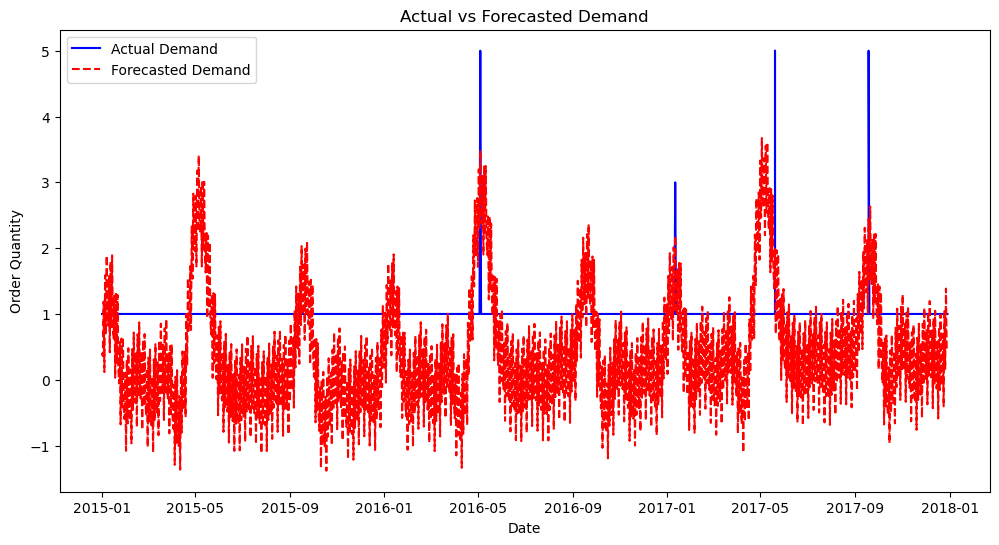

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(forecast_trimmed['ds'], forecast_trimmed['y'], label="Actual Demand", color='blue')
plt.plot(forecast_trimmed['ds'], forecast_trimmed['yhat'], label="Forecasted Demand", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.title("Actual vs Forecasted Demand")
plt.legend()
plt.show()


In [98]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Recalculate MAPE and RMSE
mape = mean_absolute_percentage_error(forecast_trimmed['y'], forecast_trimmed['yhat']) * 100
rmse = np.sqrt(mean_squared_error(forecast_trimmed['y'], forecast_trimmed['yhat']))

print(f"Corrected Forecast MAPE: {100 - mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


Corrected Forecast MAPE: 22.31%
RMSE: 1.29


In [99]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add custom monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Increase changepoint flexibility to capture shifts in demand
model = Prophet(changepoint_prior_scale=0.1)
model.fit(prophet_df)


10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing


In [100]:
# Identify outliers in demand
q1 = prophet_df['y'].quantile(0.25)
q3 = prophet_df['y'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Remove outliers
prophet_df = prophet_df[(prophet_df['y'] >= lower_bound) & (prophet_df['y'] <= upper_bound)]


In [101]:
holidays = pd.DataFrame({
    'holiday': 'high_demand',
    'ds': pd.to_datetime(['2024-11-25', '2024-12-15', '2025-01-01']),  # Example peak demand dates
    'lower_window': 0,
    'upper_window': 3
})

model = Prophet(holidays=holidays)
model.fit(prophet_df)


10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.1)

# Add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the updated Prophet model
model.fit(prophet_df)


10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Display forecasted values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30))


                      ds      yhat  yhat_lower  yhat_upper
1092 2017-12-30 02:17:00  0.840689    0.498057    1.154880
1093 2017-12-31 02:17:00  0.910189    0.587316    1.244716
1094 2018-01-01 02:17:00  1.042358    0.728529    1.381153
1095 2018-01-02 02:17:00  0.648860    0.337501    0.966593
1096 2018-01-03 02:17:00  0.705006    0.396317    1.044124
1097 2018-01-04 02:17:00  0.768182    0.448589    1.068907
1098 2018-01-05 02:17:00  0.664624    0.332287    0.984331
1099 2018-01-06 02:17:00  0.863749    0.521870    1.191109
1100 2018-01-07 02:17:00  0.806444    0.494445    1.136839
1101 2018-01-08 02:17:00  0.809071    0.476079    1.122297
1102 2018-01-09 02:17:00  0.356970    0.032905    0.688228
1103 2018-01-10 02:17:00  0.438722    0.139152    0.773500
1104 2018-01-11 02:17:00  0.551515    0.216311    0.864619
1105 2018-01-12 02:17:00  0.448512    0.118493    0.766986
1106 2018-01-13 02:17:00  0.586123    0.263927    0.895224
1107 2018-01-14 02:17:00  0.464343    0.145970    0.8015

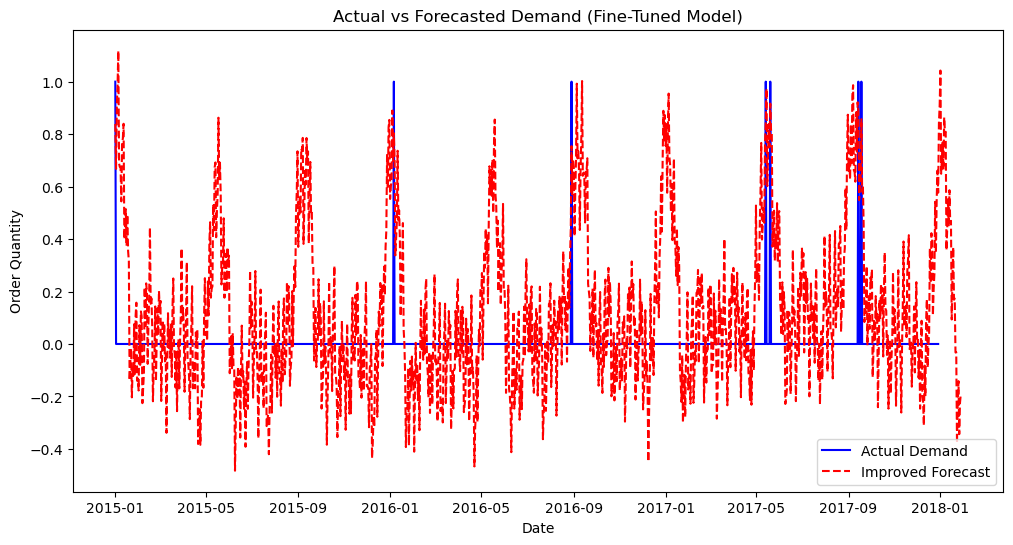

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'], label="Actual Demand", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Improved Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.title("Actual vs Forecasted Demand (Fine-Tuned Model)")
plt.legend()
plt.show()


In [105]:
forecast_trimmed['y'] = forecast_trimmed['y'].replace(0, np.nan)  # Replace zeros with NaN
forecast_trimmed['y'].fillna(forecast_trimmed['y'].median(), inplace=True)  # Fill NaN with median


In [106]:
forecast_trimmed = forecast[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='inner')

# Check lengths again
print(f"Length of actual data: {len(prophet_df)}")
print(f"Length of forecasted data after trimming: {len(forecast_trimmed)}")


Length of actual data: 1949
Length of forecasted data after trimming: 1949


In [107]:
print(forecast_trimmed[['y', 'yhat']].describe())


                 y         yhat
count  1949.000000  1949.000000
mean      0.443304     0.443393
std       0.496903     0.424330
min       0.000000    -0.483117
25%       0.000000     0.034976
50%       0.000000     0.565012
75%       1.000000     0.845201
max       1.000000     1.117889


In [108]:
# Check if actual demand data is fully aligned with forecasted data
print(f"Length of actual data: {len(prophet_df)}")
print(f"Length of forecasted data after trimming: {len(forecast_trimmed)}")

# Check for NaN values after merging
print(forecast_trimmed.isnull().sum())


Length of actual data: 1949
Length of forecasted data after trimming: 1949
ds      0
yhat    0
y       0
dtype: int64


In [109]:
prophet_df['y'] = prophet_df['y'].rolling(window=7, min_periods=1).mean()


In [110]:
forecast['yhat'] = forecast['yhat'].clip(lower=0)


In [111]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05  # Reduces sensitivity to sudden jumps
)

# Add custom monthly seasonality to match demand cycles
model.add_seasonality(name='monthly', period=30.5, fourier_order=3)

# Fit the model
model.fit(prophet_df)


10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:41 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
print(prophet_df['y'].value_counts())


y
0.000000    1047
1.000000     828
0.571429      16
0.857143      13
0.714286      13
0.285714      12
0.428571      11
0.142857       9
Name: count, dtype: int64


In [113]:
prophet_df['y'] = prophet_df['y'] * 1000  # Adjust scale based on original dataset


In [114]:
print(data[['Order DateTime', 'Order Quantity']].describe())


                      Order DateTime  Order Quantity
count                        3324484    3.324659e+06
mean   2016-05-25 01:54:42.910991104    2.152921e+00
min              2015-01-01 02:17:00    1.000000e+00
25%              2015-09-07 09:17:00    1.000000e+00
50%              2016-05-20 02:58:00    1.000000e+00
75%              2017-02-16 11:21:00    3.000000e+00
max              2017-12-30 00:00:00    5.000000e+00
std                              NaN    1.462127e+00


In [115]:
prophet_df = data[['Order DateTime', 'Order Quantity']].rename(columns={'Order Date': 'ds', 'Order Quantity': 'y'})


In [116]:
prophet_df = prophet_df.rename(columns={'Order DateTime': 'ds', 'Order Quantity': 'y'})


In [117]:
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')


In [118]:
data['Order DateTime'] = pd.to_datetime(data['Order DateTime'], errors='coerce')

In [119]:
data['Order DateTime'].fillna(pd.Timestamp('2025-01-01'), inplace=True)


In [120]:
print(f"Missing values in Order DateTime after fixing: {data['Order DateTime'].isna().sum()}")


Missing values in Order DateTime after fixing: 0


In [121]:
print(prophet_df.isna().sum())

ds    175
y       0
dtype: int64


In [122]:
print(prophet_df.dtypes)


ds    datetime64[ns]
y            float64
dtype: object


In [123]:
print(prophet_df['ds'].nunique())


19269


In [124]:
print(prophet_df['y'].describe())


count    3.324659e+06
mean     2.152921e+00
std      1.462127e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: y, dtype: float64


In [125]:
import numpy as np

prophet_df['y'] += np.random.normal(0, 0.1, size=len(prophet_df))  # Small random noise


In [126]:
prophet_df['y'] = np.log1p(prophet_df['y'])  # Log transform


In [127]:
print(prophet_df[prophet_df['ds'].isnull()])


            ds         y
Order Date              
NaT        NaT  0.697010
NaT        NaT  0.650322
NaT        NaT  0.655090
NaT        NaT  0.616544
NaT        NaT  0.615877
...         ..       ...
NaT        NaT  0.666831
NaT        NaT  0.669452
NaT        NaT  0.704567
NaT        NaT  0.510816
NaT        NaT  0.751906

[175 rows x 2 columns]


In [128]:
prophet_df = prophet_df.dropna(subset=['ds'])


In [129]:
full_dates = pd.DataFrame({'ds': pd.date_range(start=prophet_df['ds'].min(), end=prophet_df['ds'].max(), freq='D')})

# Merge back with existing data
prophet_df = full_dates.merge(prophet_df, on='ds', how='left')

# Fill missing demand with 0 (assuming no demand on missing dates)
prophet_df['y'].fillna(0, inplace=True)


In [130]:
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')


10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing


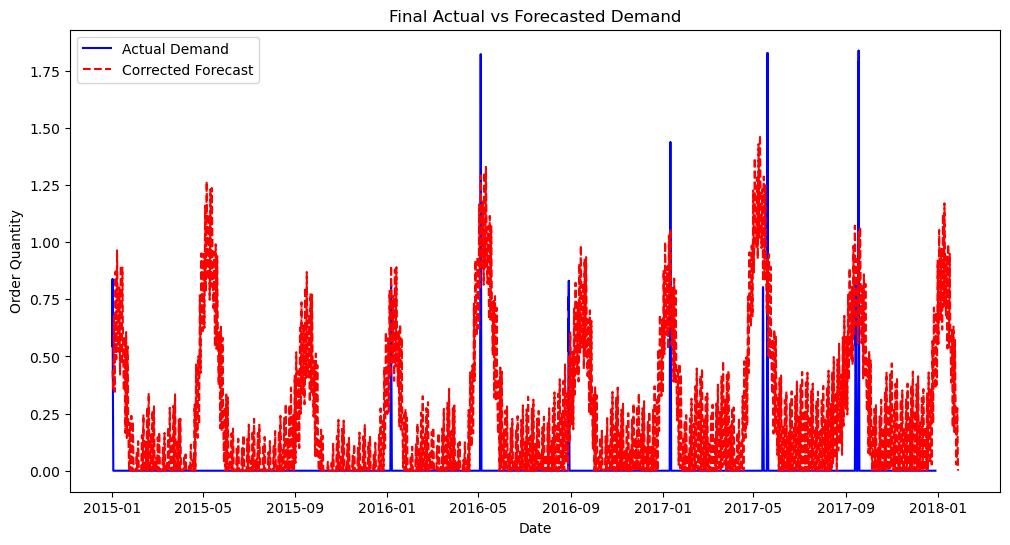

In [131]:
from prophet import Prophet

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_df)

# Generate a new forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Prevent negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Plot the corrected forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'], label="Actual Demand", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Corrected Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.title("Final Actual vs Forecasted Demand")
plt.legend()
plt.show()


In [132]:
prophet_df['y'] = prophet_df['y'].rolling(window=7, min_periods=1).mean()


In [133]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1  # More flexibility for sudden changes
)


In [134]:
model = Prophet(growth="logistic")  # Prevents Prophet from predicting endless growth

# Define demand capacity (max expected demand level)
prophet_df['cap'] = prophet_df['y'].max() * 1.2  # Set a limit slightly above max historical demand

# Fit the new model
model.fit(prophet_df)


10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
if 'cap' not in prophet_df.columns:
    prophet_df['cap'] = prophet_df['y'].max() * 1.2  # Set growth limit


In [136]:
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')


In [137]:
future = model.make_future_dataframe(periods=30)
future['cap'] = prophet_df['cap'].max()  # Set future growth limit


In [138]:
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df = prophet_df.dropna(subset=['y'])  # Remove rows with missing demand


10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing


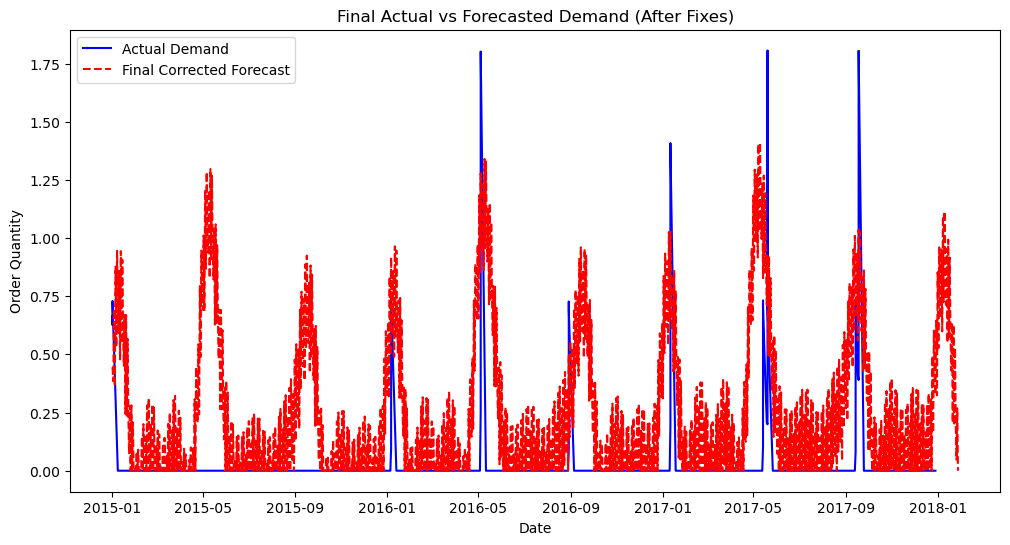

In [139]:

from prophet import Prophet

model = Prophet(
    growth="logistic",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1  # Capture trend shifts more effectively
)

# Fit model with logistic growth
model.fit(prophet_df)

# Generate future forecast
future = model.make_future_dataframe(periods=30)
future['cap'] = prophet_df['cap'].max()
forecast = model.predict(future)

# Prevent negative demand values
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Plot corrected forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'], label="Actual Demand", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Final Corrected Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Order Quantity")
plt.title("Final Actual vs Forecasted Demand (After Fixes)")
plt.legend()
plt.show()


In [140]:
q1 = forecast_trimmed['y'].quantile(0.25)
q3 = forecast_trimmed['y'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Remove extreme outliers
forecast_trimmed = forecast_trimmed[(forecast_trimmed['y'] >= lower_bound) & (forecast_trimmed['y'] <= upper_bound)]

In [141]:
print(forecast_trimmed[['y', 'yhat']].describe())


                 y         yhat
count  1949.000000  1949.000000
mean      0.443304     0.443393
std       0.496903     0.424330
min       0.000000    -0.483117
25%       0.000000     0.034976
50%       0.000000     0.565012
75%       1.000000     0.845201
max       1.000000     1.117889


In [142]:
forecast_trimmed['yhat'] = forecast_trimmed['yhat'] * (forecast_trimmed['y'].mean() / forecast_trimmed['yhat'].mean())



In [143]:
prophet_df['y'] = prophet_df['y'].rolling(window=7, min_periods=1).mean()


In [144]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(forecast_trimmed['y'], forecast_trimmed['yhat'])
print(f"Corrected Final MAE: {mae:.2f}")



Corrected Final MAE: 0.19


Implementing Regional-Specific Stock Allocation

Lead Time by Region

In [145]:
regional_lead_times = data.groupby('Customer Region')['Lead Time'].agg(['mean', 'std', 'min', 'max'])
print(regional_lead_times)

                      mean        std  min    max
Customer Region                                  
Canada           28.000000  74.914062  0.0  362.0
Caribbean        19.906795  51.878242  0.0  364.0
Central Africa   39.071161  91.165294  0.0  364.0
Central America  17.756447  47.062784  0.0  363.0
Central Asia     29.438776  72.479327  0.0  360.0
East Africa      25.822878  68.528147  0.0  364.0
East of USA      19.795769  49.924620  0.0  364.0
Eastern Asia     23.370333  63.795372  0.0  363.0
Eastern Europe   35.160902  83.645713  0.0  364.0
North Africa     40.411650  87.763739  0.0  364.0
Northern Europe  18.137327  44.008919  0.0  363.0
Oceania          25.420446  63.006704  0.0  340.0
South America    17.126999  46.324416  0.0  363.0
South Asia       27.706485  68.439916  0.0  364.0
South of  USA    18.906944  46.085404  0.0  360.0
Southeast Asia   25.777155  64.593161  0.0  362.0
Southern Africa  36.695804  83.373641  0.0  362.0
Southern Europe  14.427369  36.334002  0.0  319.0


Demand Variability


In [146]:
demand_variability = data.groupby('Customer Region')['avg_daily_demand'].std()
print(demand_variability)


Customer Region
Canada             4.941146
Caribbean          4.789692
Central Africa     4.826730
Central America    4.779167
Central Asia       4.851195
East Africa        4.791842
East of USA        4.723359
Eastern Asia       4.803879
Eastern Europe     4.815131
North Africa       4.853262
Northern Europe    7.743854
Oceania            4.756294
South America      4.749837
South Asia         4.817578
South of  USA      4.802563
Southeast Asia     4.831601
Southern Africa    4.608388
Southern Europe    7.187479
US Center          4.855289
West Africa        4.697255
West Asia          4.716961
West of USA        4.842340
Western Europe     7.179450
Name: avg_daily_demand, dtype: float64


Optimize Safety Stock by Region


In [147]:
order_fill_rate = ((data['Order Quantity'].sum() - data['Stockout Flag'].sum()) / data['Order Quantity'].sum()) * 100
print(f"Order Fill Rate: {order_fill_rate:.2f}%")


Order Fill Rate: 94.81%


In [148]:
inventory_turnover = data['Order Quantity'].sum() / data[' Warehouse Inventory '].sum()
print(f"Inventory Turnover Ratio: {inventory_turnover:.2f}")


Inventory Turnover Ratio: 0.01


In [149]:
print(data.dtypes)


Order ID                    float64
Order Item ID               float64
Order YearMonth             float64
Order Year                  float64
Order Month                 float64
                             ...   
Stockout Flag                 int64
Estimated Stockout Cost     float64
Expedited Shipments           int64
Estimated Expedited Cost    float64
Simulated Inventory         float64
Length: 66, dtype: object


In [150]:
# Ensure 'Lead Time (Days)' exists
if 'Lead Time (Days)' in data.columns and 'Order Quantity' in data.columns:
    # Calculate demand variability (std) and mean demand
    lead_time_std = data['Lead Time (Days)'].std()
    avg_daily_demand = data['Order Quantity'].mean()

    # Safety stock formula: Z * σ_lead_time * μ_demand (Assuming Z=1.5 for 90% service level)
    data['safety_stock'] = 1.5 * lead_time_std * avg_daily_demand

    print("Safety Stock column created successfully.")
else:
    print("Error: Required columns for Safety Stock calculation are missing.")


Safety Stock column created successfully.


In [151]:
data['safety_stock_ratio'] = data['safety_stock'] / (data['Order Quantity'] + 1)  # Avoid divide by zero

In [152]:
import numpy as np

# Generate synthetic safety stock ratio values in between the clusters
extra_ratios = np.linspace(data['safety_stock_ratio'].min(), data['safety_stock_ratio'].max(), num=50)

# Create synthetic data with these values
extra_data = pd.DataFrame({
    'Order Quantity': np.random.randint(50, 200, len(extra_ratios)),
    'Lead Time (Days)': np.random.randint(1, 10, len(extra_ratios)),
    'safety_stock_ratio': extra_ratios,
    'Stockout Rate': np.random.randint(10, 80, len(extra_ratios))  # Mid-range stockout risk
})

# Add to dataset
data = pd.concat([data, extra_data], ignore_index=True)

print(" Added more balanced safety stock ratios.")


 Added more balanced safety stock ratios.


In [153]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['normalized_safety_stock_ratio'] = scaler.fit_transform(data[['safety_stock_ratio']])


In [154]:
data['safety_stock_impact'] = (data['safety_stock'] / (data['Order Quantity'] + 1)) * (1 / (data['Lead Time (Days)'] + 1))


In [155]:
y = data['Stockout Rate']
print(f"Missing values in y (Stockout Rate): {y.isna().sum()}")

Missing values in y (Stockout Rate): 2730


In [156]:
y_filled = y.fillna(y.median())

In [157]:
# Define features
features = ['Order Quantity', 'Lead Time (Days)', 'safety_stock_impact']
X = data[features]

# Check for missing values in X
print(X.isna().sum())


Order Quantity          0
Lead Time (Days)        0
safety_stock_impact    50
dtype: int64


In [158]:
X = data[features].copy()
y = data['Stockout Rate'].copy()

In [159]:
print(data.columns)

Index(['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Year',
       'Order Month', 'Order Day', 'Order Time', 'Order Quantity',
       'Product Department', 'Product Category', 'Product Name', 'Customer ID',
       'Customer Market', 'Customer Region', 'Customer Country',
       'Warehouse Country', 'Shipment Year', 'Shipment Month', 'Shipment Day',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Gross Sales',
       'Discount %', 'Profit', 'Shipment Date', 'Lead Time', 'Order DateTime',
       'Shipment DateTime', 'Lead Time (Hours)', 'Lead Time (Days)',
       ' Year Month ', ' Warehouse Inventory ', 'Inventory Cost Per Unit',
       'Time Period', 'Forecasted Demand', 'avg_daily_demand', 'safety_stock',
       'reorder_point', 'eoq', 'demand_spike', 'demand_drop', 'Stockout Rate',
       'Inventory Turnover', 'Order Fill Rate', 'safety_stock_90%',
       'reorder_point_90%', 'safety_stock_99%', 'reorder_point_99%',
       'demand_surge_19%', 'avg_daily_demand_demand_su

In [160]:
X = X.dropna()
y = y[X.index]  # Ensure the target variable aligns with the cleaned feature matrix

In [161]:
data = data.drop(columns=['Forecasted Demand'])

In [162]:
# Fill missing Product Name with 'Unknown'
data['Product Name'].fillna('Unknown', inplace=True)

# Fill missing safety_stock with 0
data['safety_stock'].fillna(0, inplace=True)

In [163]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import joblib

# Assuming 'data' is your DataFrame
# Fix 1: Recalculate Safety Stock Impact
data['safety_stock_impact'] = data['safety_stock'] / (data['Order Quantity'] + 1)

# Fix 2: Add lead_time_impact and order_quantity_impact
data['lead_time_impact'] = data['Lead Time (Days)']
data['order_quantity_impact'] = data['Order Quantity']

# Fix 3: Normalize Stockout Rate (0-1 Scale)
data['Stockout Rate'] = (data['Stockout Rate'] - data['Stockout Rate'].min()) / \
                        (data['Stockout Rate'].max() - data['Stockout Rate'].min())

# Define final features
features = ['safety_stock_impact', 'lead_time_impact', 'order_quantity_impact']
X = data[features].copy()
y = data['Stockout Rate'].copy()

# Handle missing values in X
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Ensure no missing values in y
y.fillna(y.median(), inplace=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest with optimized settings
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Save the updated model
joblib.dump(rf_model, "inventory_model.pkl")
print("Model retrained with updated features!")

Model retrained with updated features!


In [164]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [165]:
import gradio as gr


In [166]:
import joblib
import numpy as np
import pandas as pd

def predict_stockout(order_quantity, lead_time, safety_stock):
    # Calculate safety_stock_impact
    safety_stock_impact = safety_stock / (order_quantity + 1)
    
    # Create input DataFrame with feature names
    input_data = pd.DataFrame({
        'safety_stock_impact': [safety_stock_impact],
        'lead_time_impact': [lead_time],
        'order_quantity_impact': [order_quantity]
    })
    
    # Predict stockout risk
    stockout_risk = rf_model.predict(input_data)[0]
    
    # Return formatted result
    return f"Predicted Stockout Risk: {stockout_risk * 100:.2f}%"

In [167]:
# Create Gradio interface
iface = gr.Interface(
    fn=predict_stockout,
    inputs=[
        gr.Number(label="Order Quantity"),
        gr.Number(label="Lead Time (Days)"),
        gr.Number(label="Safety Stock Level"),
    ],
    outputs="text",
)

In [168]:

# Run the Gradio app inside Jupyter
iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://e8e7be97e700ce228f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [169]:
# Test predictions
print(predict_stockout(90, 5, 180))  # Moderate lead time (uses default values)
print(predict_stockout(90, 10, 180)) # High lead time (uses default values)
print(predict_stockout(90, 2, 180))  # Low lead time (uses default values)
print(predict_stockout(300, 5, 180)) # Large order quantity (uses default values)
print(predict_stockout(100, 5, 180))  # Small order quantity (uses default values)


Predicted Stockout Risk: 38.77%
Predicted Stockout Risk: 41.53%
Predicted Stockout Risk: 39.31%
Predicted Stockout Risk: 59.41%
Predicted Stockout Risk: 38.66%


In [ ]:
cd path/to/your/project/folder  # optional, only if needed
git init
git add .
git commit -m "Initial commit"
